In [1]:
from typing import Union, Dict

import numpy as np
import pandas as pd

from axisfuzzy.fuzzifier import Fuzzifier

from axisfuzzy.analysis.dataframe import FuzzyDataFrame
from axisfuzzy.analysis.pipeline import FuzzyPipeline
from axisfuzzy.analysis.component.basic import ToolNormalization, ToolFuzzification, ToolSimpleAggregation, ToolWeightNormalization
from axisfuzzy.analysis.component.base import AnalysisComponent
from axisfuzzy.analysis.contracts import contract, Contract
from axisfuzzy.analysis.build_in import ContractCrispTable, ContractStatisticsDict, ContractWeightVector

In [2]:
ContractAboveThresholdData = Contract('ContractAboveThresholdData', ContractCrispTable.validate, parent=ContractCrispTable)
ContractBelowThresholdData = Contract('ContractBelowThresholdData', ContractCrispTable.validate, parent=ContractCrispTable)
ContractSplitStats = Contract('ContractSplitStats', ContractStatisticsDict.validate, parent=ContractStatisticsDict)

class ToolDataSplitter(AnalysisComponent):
    """根据阈值分割数据并提供统计信息"""
    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold

    def get_config(self) -> dict:
        return {'threshold': self.threshold}

    @contract
    def run(self, data: ContractCrispTable) -> Dict[str, Union[ContractAboveThresholdData, ContractBelowThresholdData, ContractSplitStats]]:
        """
        Splits a DataFrame into two based on a threshold and provides statistics.
        The return type annotation now uses distinct Contract types for each output.
        """
        df_above = data[data > self.threshold].fillna(0)
        df_below = data[data <= self.threshold].fillna(0)

        stats = {
            'above_mean': float(df_above.mean().mean()),
            'below_mean': float(df_below.mean().mean()),
            'threshold': self.threshold
        }
        # 实际返回的字典键名在这里可以任意，因为管道会根据类型注解中的 Contract 名称来生成 StepOutput 的键。
        # 但为了清晰，我们仍然使用有意义的键名。
        return {
            ContractAboveThresholdData.name.lower(): df_above,  # 'contractabovethresholddata'
            ContractBelowThresholdData.name.lower(): df_below,  # 'contractbelowthresholddata'
            ContractSplitStats.name.lower(): stats              # 'contractsplitstats'
        }

In [3]:
print("--- axisfuzzy 模糊数据分析系统全面执行示例 ---")
print("------------------------------------------\n")

# 1. 准备模拟数据
print("1. 准备模拟数据")
raw_data_df = pd.DataFrame(np.random.rand(5, 3), columns=['FeatureA', 'FeatureB', 'FeatureC'])
raw_weights_series = pd.Series(np.array([0.2, 0.5, 0.3]), index=['W1', 'W2', 'W3'])
print("原始数据 (raw_data_df):\n", raw_data_df)
print("\n原始权重 (raw_weights_series):\n", raw_weights_series)
print("-" * 50)

--- axisfuzzy 模糊数据分析系统全面执行示例 ---
------------------------------------------

1. 准备模拟数据
原始数据 (raw_data_df):
    FeatureA  FeatureB  FeatureC
0  0.111419  0.157022  0.971896
1  0.698477  0.826664  0.874686
2  0.695921  0.058808  0.219771
3  0.569087  0.638068  0.301118
4  0.168955  0.880838  0.575174

原始权重 (raw_weights_series):
 W1    0.2
W2    0.5
W3    0.3
dtype: float64
--------------------------------------------------



2. 场景一：单输入 -> 单输出管道 (数据归一化)
运行管道: SingleOutputPipeline
归一化结果 (result_normalized):
    FeatureA  FeatureB  FeatureC
0  0.000000  0.119478  1.000000
1  1.000000  0.934097  0.870753
2  0.995647  0.000000  0.000000
3  0.779596  0.704670  0.108157
4  0.098008  1.000000  0.472533


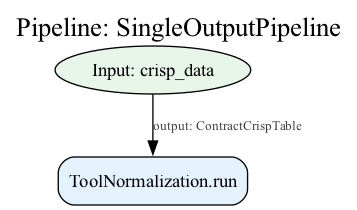

In [4]:
# 2. 场景一：单输入 -> 单输出管道
print("\n2. 场景一：单输入 -> 单输出管道 (数据归一化)")
pipeline_single_output = FuzzyPipeline(name="SingleOutputPipeline")

# 定义输入
input_data = pipeline_single_output.input("crisp_data", contract=ContractCrispTable)

# 添加归一化组件
normalizer = ToolNormalization(method='min_max', axis=0) # 按列归一化
normalized_data = pipeline_single_output.add(normalizer.run, data=input_data)

# 运行管道
print(f"运行管道: {pipeline_single_output.name}")
result_normalized = pipeline_single_output.run(raw_data_df)
print("归一化结果 (result_normalized):\n", result_normalized)
pipeline_single_output.visualize()


3. 场景二：多输入 -> 多输出管道 (数据处理与统计 - 修正版)
多输入多输出管道结果 (results_multi_io):


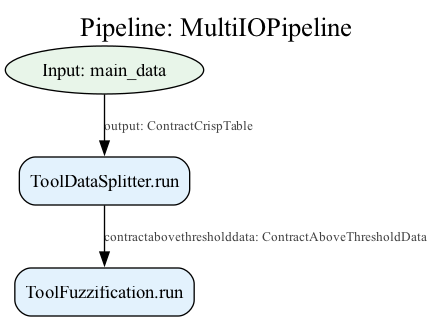

In [5]:
# 3. 场景二：多输入 -> 多输出管道 (修正后的版本)
print("\n3. 场景二：多输入 -> 多输出管道 (数据处理与统计 - 修正版)")
pipeline_multi_io = FuzzyPipeline(name="MultiIOPipeline")

# 定义多个输入
input_main_data = pipeline_multi_io.input("main_data", contract=ContractCrispTable)

# 添加多输出组件 (ToolDataSplitter)
data_splitter = ToolDataSplitter(threshold=0.6)
# 注意：这里 input_threshold 是一个 StepOutput，但 ToolDataSplitter 的 __init__ 接受的是静态参数
# 实际应用中，如果 threshold 是动态的，ToolDataSplitter.run 应该接受 threshold 作为参数
# 为了演示，我们在这里将 threshold 作为静态参数传递给 add 方法
split_outputs = pipeline_multi_io.add(data_splitter.run, data=input_main_data)
# 从多输出中获取特定输出 - 使用 Contract 的小写名称作为键
data_above_threshold = split_outputs["contractabovethresholddata"]
data_below_threshold = split_outputs["contractbelowthresholddata"]
split_stats = split_outputs["contractsplitstats"]

# 添加其他组件，使用上一步的某个输出
fuzzifier_tool = ToolFuzzification(fuzzifier=Fuzzifier(mf='GaussianMF', mf_params=[{"sigma": 0.2, "c": 0.5}]))
fuzzy_data_above = pipeline_multi_io.add(fuzzifier_tool.run, data=data_above_threshold)

# 运行管道
# print(f"运行管道: {pipeline_multi_io.name}")
# # 注意：这里 initial_data 必须是字典，键与 input() 定义的名称匹配
# results_multi_io = pipeline_multi_io.run(initial_data={
#     "main_data": raw_data_df,
#     # "split_threshold": 0.6 # 静态参数在构建时传入，这里只是为了匹配 input() 定义
# })
print("多输入多输出管道结果 (results_multi_io):")
# 访问最终结果时，如果终端节点有多个输出，其键名会是 '步骤显示名称_Contract小写名称'
pipeline_multi_io.visualize()


4. 场景三：嵌套管道 (数据预处理子管道)
运行管道: MainPipelineWithSub
嵌套管道结果 (results_nested):
  - PreprocessingSubPipeline_output (处理后的数据):
 0    7.401487e-17
1   -4.070818e-16
2    7.401487e-17
3   -2.220446e-16
4   -1.526557e-16
dtype: float64
  - ToolWeightNormalization_output (归一化权重):
 W1    0.2
W2    0.5
W3    0.3
dtype: float64


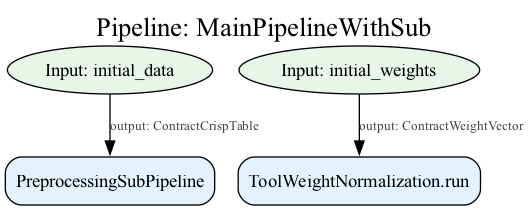

In [6]:
# 4. 场景三：嵌套管道
print("\n4. 场景三：嵌套管道 (数据预处理子管道)")
# 定义一个子管道
sub_pipeline = FuzzyPipeline(name="PreprocessingSubPipeline")
sub_input = sub_pipeline.input("sub_raw_data", contract=ContractCrispTable)
sub_normalized = sub_pipeline.add(ToolNormalization(method='z_score').run, data=sub_input)
sub_aggregated = sub_pipeline.add(ToolSimpleAggregation(operation='mean', axis=1).run, data=sub_normalized)

# 定义主管道
main_pipeline = FuzzyPipeline(name="MainPipelineWithSub")
main_input_data = main_pipeline.input("initial_data", contract=ContractCrispTable)
main_input_weights = main_pipeline.input("initial_weights", contract=ContractWeightVector)

# 将子管道作为主管道的一个步骤添加
# 注意：sub_pipeline 的输入 'sub_raw_data' 对应 main_input_data
processed_data_from_sub = main_pipeline.add(sub_pipeline, sub_raw_data=main_input_data)

# 添加权重归一化
weight_normalizer = ToolWeightNormalization()
normalized_weights = main_pipeline.add(weight_normalizer.run, weights=main_input_weights)

# 运行主管道
print(f"运行管道: {main_pipeline.name}")
results_nested = main_pipeline.run(initial_data={
    "initial_data": raw_data_df,
    "initial_weights": raw_weights_series
})
print("嵌套管道结果 (results_nested):")
print("  - PreprocessingSubPipeline_output (处理后的数据):\n", results_nested['PreprocessingSubPipeline'])
print("  - ToolWeightNormalization_output (归一化权重):\n", results_nested['ToolWeightNormalization.run'])
main_pipeline.visualize()

In [7]:
# 5. 场景四：逐步执行 (Step-by-Step Execution)
print("\n5. 场景四：逐步执行 (Step-by-Step Execution)")
print("使用 main_pipeline 进行逐步执行...")

# 重新运行 main_pipeline，但这次使用 step_by_step
iterator = main_pipeline.step_by_step(initial_data={
    "initial_data": raw_data_df,
    "initial_weights": raw_weights_series
})

for i, step_info in enumerate(iterator):
    print(f"\n--- 步骤 {i+1}/{step_info['total_steps']}: {step_info['step_name']} ---")
    print(f"  步骤ID: {step_info['step_id'][:8]}...")
    print(f"  执行时间: {step_info['execution_time']:.4f} 秒")
    print(f"  结果类型: {type(step_info['result'])}")
    if isinstance(step_info['result'], (pd.DataFrame, pd.Series, FuzzyDataFrame)):
        print("  结果预览:\n", step_info['result'].head(2) if hasattr(step_info['result'], 'head') else step_info['result'])
    elif isinstance(step_info['result'], dict):
        print("  结果键:\n", list(step_info['result'].keys()))
    else:
        print("  结果:\n", step_info['result'])
print("\n所有步骤执行完毕。")
print("-" * 50)


5. 场景四：逐步执行 (Step-by-Step Execution)
使用 main_pipeline 进行逐步执行...

--- 步骤 1/2: PreprocessingSubPipeline ---
  步骤ID: Preproce...
  执行时间: 1.8946 秒
  结果类型: <class 'pandas.core.series.Series'>
  结果预览:
 0    7.401487e-17
1   -4.070818e-16
dtype: float64

--- 步骤 2/2: ToolWeightNormalization.run ---
  步骤ID: ToolWeig...
  执行时间: 0.0560 秒
  结果类型: <class 'pandas.core.series.Series'>
  结果预览:
 W1    0.2
W2    0.5
dtype: float64

所有步骤执行完毕。
--------------------------------------------------


In [8]:
# 6. 场景五：契约验证失败 (Graph-Time Contract Validation Failure)
print("\n6. 场景五：契约验证失败 (Graph-Time Contract Validation Failure)")
print("尝试连接不兼容的契约...")
pipeline_invalid = FuzzyPipeline(name="InvalidPipeline")
invalid_input = pipeline_invalid.input("some_data", contract=ContractCrispTable)

try:
    # 尝试将 ContractCrispTable 传递给期望 ContractWeightVector 的组件
    # ToolWeightNormalization.run 期望 weights: ContractWeightVector
    pipeline_invalid.add(ToolWeightNormalization().run, weights=invalid_input)
except TypeError as e:
    print(f"成功捕获图构建时契约不兼容错误: {e}")
print("-" * 50)


6. 场景五：契约验证失败 (Graph-Time Contract Validation Failure)
尝试连接不兼容的契约...
成功捕获图构建时契约不兼容错误: Contract incompatibility for 'ToolWeightNormalization.run' on input 'weights'. Expected compatible with 'ContractWeightVector', but received a promise for 'ContractCrispTable' from step 'Input: some_data'.
--------------------------------------------------


In [9]:
# 7. 场景六：运行时契约验证失败 (Runtime Contract Validation Failure)
print("\n7. 场景六：运行时契约验证失败 (Runtime Contract Validation Failure)")
print("尝试在运行时传入不符合契约的数据...")
pipeline_runtime_invalid = FuzzyPipeline(name="RuntimeInvalidPipeline")
runtime_input = pipeline_runtime_invalid.input("data_for_norm", contract=ContractCrispTable)
runtime_normalizer = ToolNormalization(method='min_max')
pipeline_runtime_invalid.add(runtime_normalizer.run, data=runtime_input)

try:
    # 传入一个非 DataFrame 的数据 (例如一个列表)，这不符合 ContractCrispTable 的要求
    print("尝试用列表运行管道，期望 ContractCrispTable...")
    pipeline_runtime_invalid.run(initial_data=[1, 2, 3])
except TypeError as e:
    print(f"成功捕获运行时契约验证错误: {e}")
print("-" * 50)


7. 场景六：运行时契约验证失败 (Runtime Contract Validation Failure)
尝试在运行时传入不符合契约的数据...
尝试用列表运行管道，期望 ContractCrispTable...
成功捕获运行时契约验证错误: Runtime contract validation failed for 'ToolNormalization.run' on input 'data'. Expected 'ContractCrispTable', but received object of type list.
--------------------------------------------------
